# RealWaste — MobileNetV2 (Using Manifest + Numpy Splits)

Loads dataset from your `.npy` splits (`filepaths.npy`, `labels_encoded.npy`, `class_names.npy`,
`split_train.npy`, `split_val.npy`, `split_test.npy`, optional `mean_std.npy`), fine-tunes
**MobileNetV2**, and reports Accuracy + macro Precision/Recall/F1 + confusion matrix.


In [1]:
# (Optional) Installs (uncomment if needed)
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install scikit-learn matplotlib pandas tqdm pillow numpy


In [2]:

from pathlib import Path
import numpy as np

SPLITS_DIR = Path("C:/Users/User/Desktop/CNN asignment/code/pre_trained_models")  # change if your npy files are elsewhere

FILEPATHS_NPY = SPLITS_DIR / "filepaths.npy"
LABELS_NPY    = SPLITS_DIR / "labels_encoded.npy"
CLASSES_NPY   = SPLITS_DIR / "class_names.npy"
TRAIN_NPY     = SPLITS_DIR / "split_train.npy"
VAL_NPY       = SPLITS_DIR / "split_val.npy"
TEST_NPY      = SPLITS_DIR / "split_test.npy"
MEAN_STD_NPY  = SPLITS_DIR / "mean_std.npy"

OUTPUT_DIR = Path("./outputs/mobilenetv2_realwaste_splits").resolve()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SEED = 133
BATCH_SIZE = 32
HEAD_EPOCHS = 5
FT_EPOCHS = 20
BASE_LR = 3e-4
WEIGHT_DECAY = 1e-4
LABEL_SMOOTH = 0.1
IMG_SIZE = 224


In [3]:

import random, os, numpy as np, torch
def set_seed(seed=133):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [4]:

# Load arrays
filepaths = np.load(FILEPATHS_NPY, allow_pickle=True)
labels    = np.load(LABELS_NPY)
classes   = np.load(CLASSES_NPY, allow_pickle=True).tolist()
idx_tr    = np.load(TRAIN_NPY); idx_va = np.load(VAL_NPY); idx_te = np.load(TEST_NPY)

try:
    mean_std = np.load(MEAN_STD_NPY)
    mean = mean_std[0].tolist(); std = mean_std[1].tolist()
    print("Using dataset mean/std:", mean, std)
except Exception:
    mean = [0.485, 0.456, 0.406]; std = [0.229, 0.224, 0.225]
    print("No mean_std.npy found; using ImageNet stats.")

len(classes), classes[:5], len(idx_tr), len(idx_va), len(idx_te)


Using dataset mean/std: [0.598393759260575, 0.6187966115872066, 0.6307503436009089] [0.1635656363186559, 0.1645716954870396, 0.18778279659653346]


(9,
 ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash'],
 3326,
 713,
 713)

In [5]:

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class NpySplitDataset(Dataset):
    def __init__(self, filepaths, labels, indices, img_size=224, train=True, mean=None, std=None):
        self.filepaths=filepaths; self.labels=labels; self.indices=indices; self.train=train
        self.mean = mean or [0.485,0.456,0.406]; self.std = std or [0.229,0.224,0.225]
        if train:
            self.tf = transforms.Compose([
                transforms.Resize(int(img_size*1.15)), transforms.CenterCrop(img_size),
                transforms.RandomHorizontalFlip(p=0.5), transforms.ColorJitter(0.1,0.1,0.1,0.05),
                transforms.ToTensor(), transforms.Normalize(self.mean,self.std),
            ])
        else:
            self.tf = transforms.Compose([
                transforms.Resize(int(img_size*1.15)), transforms.CenterCrop(img_size),
                transforms.ToTensor(), transforms.Normalize(self.mean,self.std),
            ])
    def __len__(self): return len(self.indices)
    def __getitem__(self,i):
        idx=int(self.indices[i]); fp=str(self.filepaths[idx]); y=int(self.labels[idx])
        img=Image.open(fp).convert("RGB"); x=self.tf(img); return x,y

train_ds=NpySplitDataset(filepaths,labels,idx_tr,IMG_SIZE,True,mean,std)
val_ds  =NpySplitDataset(filepaths,labels,idx_va,IMG_SIZE,False,mean,std)
test_ds =NpySplitDataset(filepaths,labels,idx_te,IMG_SIZE,False,mean,std)

train_dl=DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True,num_workers=0,pin_memory=True)
val_dl  =DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=False,num_workers=0,pin_memory=True)
test_dl =DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=False,num_workers=0,pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)


(3326, 713, 713)

In [6]:

import torch.nn as nn
from torchvision import models
m = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
m.classifier[1] = nn.Linear(m.classifier[1].in_features, len(classes))
model = m.to(device)
classifier_params = list(m.classifier[1].parameters())


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\User/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:01<00:00, 7.37MB/s]


In [7]:

import torch, torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

def train_one_epoch(model, dl, optimizer, device, smoothing=0.1):
    model.train(); total=correct=0; loss_sum=0.0
    for x,y in tqdm(dl, leave=False):
        x,y=x.to(device),y.to(device); optimizer.zero_grad()
        out=model(x); loss=F.cross_entropy(out,y,label_smoothing=smoothing); pred=out.argmax(1)
        loss.backward(); optimizer.step()
        bs=y.size(0); loss_sum+=loss.item()*bs; correct+=(pred==y).sum().item(); total+=bs
    return loss_sum/total, correct/total

@torch.no_grad()
def evaluate(model, dl, device):
    model.eval(); total=correct=0; loss_sum=0.0
    for x,y in dl:
        x,y=x.to(device),y.to(device); out=model(x); loss=F.cross_entropy(out,y); pred=out.argmax(1)
        bs=y.size(0); loss_sum+=loss.item()*bs; correct+=(pred==y).sum().item(); total+=bs
    return loss_sum/total, correct/total


In [8]:

# 1) Train classifier head only
for p in model.parameters(): p.requires_grad=False
for p in classifier_params: p.requires_grad=True

opt=AdamW(filter(lambda p:p.requires_grad, model.parameters()), lr=BASE_LR, weight_decay=WEIGHT_DECAY)
sch=CosineAnnealingLR(opt, T_max=HEAD_EPOCHS)

best_val_acc=-1.0; best_state=None
for ep in range(1, HEAD_EPOCHS+1):
    tr_loss,tr_acc=train_one_epoch(model, train_dl, opt, device, smoothing=LABEL_SMOOTH)
    va_loss,va_acc=evaluate(model, val_dl, device); sch.step()
    print(f"[head][{ep:02d}/{HEAD_EPOCHS}] train_acc={tr_acc:.4f}  val_acc={va_acc:.4f}")
    if va_acc>best_val_acc:
        best_val_acc=va_acc; best_state={k:v.cpu() for k,v in model.state_dict().items()}

from pathlib import Path; import torch
if best_state is not None:
    head_ckpt=Path(OUTPUT_DIR)/"mobilenetv2_head_best.pth"
    torch.save(best_state, head_ckpt); print("Saved:", head_ckpt)


[head][01/5] train_acc=0.4218  val_acc=0.6900


[head][02/5] train_acc=0.6551  val_acc=0.7181


[head][03/5] train_acc=0.7072  val_acc=0.7335


[head][04/5] train_acc=0.7264  val_acc=0.7433


[head][05/5] train_acc=0.7273  val_acc=0.7363
Saved: C:\Users\User\Desktop\CNN asignment\code\pre_trained_models\outputs\mobilenetv2_realwaste_splits\mobilenetv2_head_best.pth


In [9]:

# 2) Fine-tune all layers
for p in model.parameters(): p.requires_grad=True
opt=AdamW(model.parameters(), lr=BASE_LR/3, weight_decay=WEIGHT_DECAY)
sch=CosineAnnealingLR(opt, T_max=FT_EPOCHS)

best_val_acc=-1.0; best_state=None
for ep in range(1, FT_EPOCHS+1):
    tr_loss,tr_acc=train_one_epoch(model, train_dl, opt, device, smoothing=LABEL_SMOOTH)
    va_loss,va_acc=evaluate(model, val_dl, device); sch.step()
    print(f"[ft  ][{ep:02d}/{FT_EPOCHS}] train_acc={tr_acc:.4f}  val_acc={va_acc:.4f}")
    if va_acc>best_val_acc:
        best_val_acc=va_acc; best_state={k:v.cpu() for k,v in model.state_dict().items()}

best_ckpt=Path(OUTPUT_DIR)/"mobilenetv2_best.pth"
if best_state is not None:
    torch.save(best_state, best_ckpt); print("Saved best fine-tuned checkpoint:", best_ckpt)


[ft  ][01/20] train_acc=0.7922  val_acc=0.8808


[ft  ][02/20] train_acc=0.9077  val_acc=0.8920


[ft  ][03/20] train_acc=0.9531  val_acc=0.9116


[ft  ][04/20] train_acc=0.9781  val_acc=0.9215


[ft  ][05/20] train_acc=0.9889  val_acc=0.9116


[ft  ][06/20] train_acc=0.9937  val_acc=0.9173


[ft  ][07/20] train_acc=0.9964  val_acc=0.9243


[ft  ][08/20] train_acc=0.9976  val_acc=0.9144


[ft  ][09/20] train_acc=0.9991  val_acc=0.9355


[ft  ][10/20] train_acc=0.9991  val_acc=0.9229


[ft  ][11/20] train_acc=0.9997  val_acc=0.9257


[ft  ][12/20] train_acc=0.9997  val_acc=0.9229


[ft  ][13/20] train_acc=1.0000  val_acc=0.9229


[ft  ][14/20] train_acc=1.0000  val_acc=0.9243


[ft  ][15/20] train_acc=1.0000  val_acc=0.9243


[ft  ][16/20] train_acc=1.0000  val_acc=0.9271


[ft  ][17/20] train_acc=1.0000  val_acc=0.9285


[ft  ][18/20] train_acc=0.9997  val_acc=0.9285


[ft  ][19/20] train_acc=0.9997  val_acc=0.9243


[ft  ][20/20] train_acc=1.0000  val_acc=0.9257
Saved best fine-tuned checkpoint: C:\Users\User\Desktop\CNN asignment\code\pre_trained_models\outputs\mobilenetv2_realwaste_splits\mobilenetv2_best.pth


In [10]:

from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import pandas as pd, numpy as np, torch

@torch.no_grad()
def predict_all(model, dl, device):
    model.eval(); ys=[]; ps=[]
    for x,y in dl:
        x=x.to(device); out=model(x); pred=out.argmax(1).cpu().numpy()
        ys.append(y.numpy()); ps.append(pred)
    y=np.concatenate(ys); p=np.concatenate(ps); return y,p

state=torch.load(best_ckpt, map_location="cpu"); model.load_state_dict(state)
test_loss,test_acc=evaluate(model, test_dl, device); y_true,y_pred=predict_all(model,test_dl,device)

acc=accuracy_score(y_true,y_pred)
prec,rec,f1,_=precision_recall_fscore_support(y_true,y_pred,average="macro",zero_division=0)
print("Test Accuracy:", acc); print("Macro Precision:", prec); print("Macro Recall:", rec); print("Macro F1:", f1)

df=pd.DataFrame([{"model":"mobilenetv2","accuracy":acc,"precision_macro":prec,"recall_macro":rec,"f1_macro":f1}])
csv_path=Path(OUTPUT_DIR)/"results.csv"; df.to_csv(csv_path,index=False); csv_path


Test Accuracy: 0.9256661991584852
Macro Precision: 0.9293767470761762
Macro Recall: 0.930909005638401
Macro F1: 0.929672590783085


WindowsPath('C:/Users/User/Desktop/CNN asignment/code/pre_trained_models/outputs/mobilenetv2_realwaste_splits/results.csv')

WindowsPath('C:/Users/User/Desktop/CNN asignment/code/pre_trained_models/outputs/mobilenetv2_realwaste_splits/confusion_matrix_mobilenetv2_realwaste_splits.png')

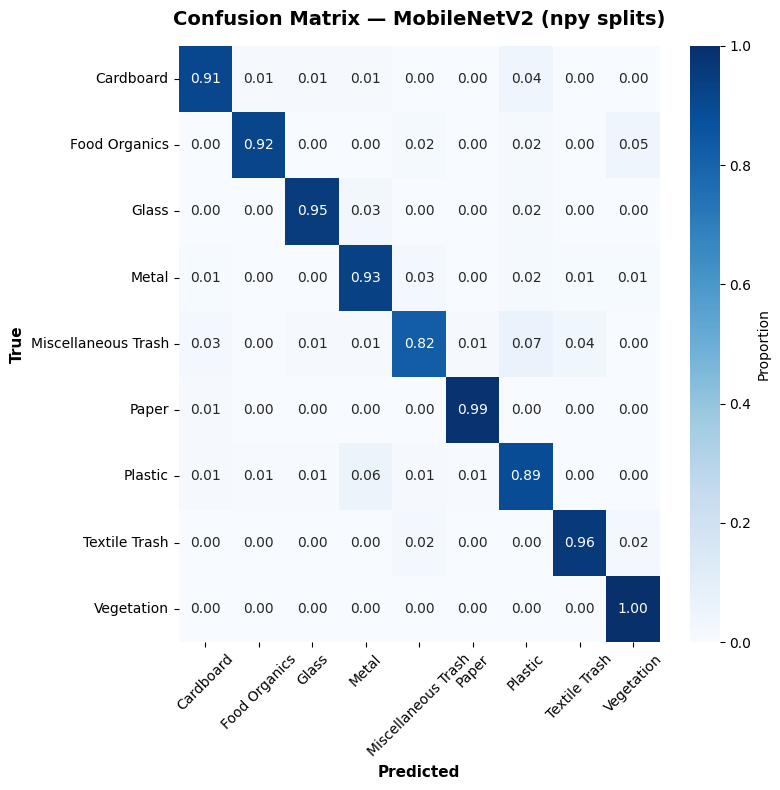

In [12]:
import matplotlib.pyplot as plt, numpy as np, seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Proportion'}, vmin=0, vmax=1)
plt.title('Confusion Matrix — MobileNetV2 (npy splits)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Predicted', fontsize=11, fontweight='bold')
plt.ylabel('True', fontsize=11, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

cm_path = Path(OUTPUT_DIR)/"confusion_matrix_mobilenetv2_realwaste_splits.png"
plt.savefig(cm_path, dpi=150, bbox_inches="tight")
cm_path
